In [2]:
import numpy as np
import random
import json
import copy
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [3]:
def eliminacao_gauss(A, b, max_iter):
    n = len(A)
    for i in range(n):
        max_index = max(range(i, n), key=lambda k: abs(A[k][i]))
        if A[max_index][i] == 0:
            raise ValueError(f"A matriz é singular, não é possível resolver o sistema para a linha {i}.")
        if max_index != i:
            A[i], A[max_index] = A[max_index], A[i]
            b[i], b[max_index] = b[max_index], b[i]
        for k in range(i + 1, n):
            fator = A[k][i] / A[i][i]
            for j in range(i, n):
                A[k][j] -= fator * A[i][j]
            b[k] -= fator * b[i]
    x = [0] * n
    for i in range(n - 1, -1, -1):
        soma = sum(A[i][j] * x[j] for j in range(i + 1, n))
        x[i] = (b[i] - soma) / A[i][i]
    for _ in range(max_iter):
        r = [b[i] - sum(A[i][j] * x[j] for j in range(n)) for i in range(n)]
        delta_x = [0] * n
        for i in range(n - 1, -1, -1):
            soma = sum(A[i][j] * delta_x[j] for j in range(i + 1, n))
            delta_x[i] = (r[i] - soma) / A[i][i]
        x = [x[i] + delta_x[i] for i in range(n)]
    
    return x

In [4]:
def metodo_jacobi(A, b, max_iter, tol=1e-6):
    n = len(A)
    x = [0] * n 
    x_novo = x[:]
    for _ in range(max_iter):
        for i in range(n):
            soma = sum(A[i][j] * x[j] for j in range(n) if j != i)
            x_novo[i] = (b[i] - soma) / A[i][i]
        if max(abs(x_novo[i] - x[i]) for i in range(n)) < tol:
            return x_novo
        x = x_novo[:]
    return x_novo

In [5]:
def metodo_gauss_seidel(A, b, max_iter, tol=1e-6):
    n = len(A)
    x = [0] * n 
    for _ in range(max_iter):
        x_old = x[:]
        for i in range(n):
            soma = sum(A[i][j] * x[j] for j in range(n) if j != i)
            x[i] = (b[i] - soma) / A[i][i]
        if max(abs(x[i] - x_old[i]) for i in range(n)) < tol:
            return x
    return x

In [6]:
class Individual:
    def __init__(self, initial_positions: List[List[float]], min_matrix: List[List[float]], 
                 max_matrix: List[List[float]], b_vector: List[float]):
        self.initial_positions = initial_positions
        self.min_matrix = min_matrix
        self.max_matrix = max_matrix
        self.b_vector = b_vector
        self.n = len(initial_positions)
        self.graph = self._initialize_graph()
    
    def _initialize_graph(self) -> List[List[float]]:
        graph = [[0.0] * self.n for _ in range(self.n)]
        for i in range(self.n):
            for j in range(self.n):
                if self.max_matrix[i][j] > 0:
                    val = self.initial_positions[i][j] * random.uniform(
                        self.min_matrix[i][j], self.max_matrix[i][j])
                    graph[i][j] = val
                    graph[j][i] = val
        return graph

    def fitness(self, tester: List[List[float]]) -> float:
        n = len(self.initial_positions)
        A = [[0.0] * n for _ in range(n)]
        for i in range(n):
            for j in range(n):
                A[i][j] = self.initial_positions[i][j] * tester[i][j]
        
        try:
            solution = eliminacao_gauss(A, self.b_vector.copy(), 5)
            total_abs = sum(abs(x) for x in solution) 
            if total_abs == 0:
                return 0.0
            return 10.0 * n / total_abs
        except ValueError:  # Capturar erro de matriz singular
            return 0.0

    def mutate(self, mutation_rate: float) -> 'Individual':
        new_positions = copy.deepcopy(self.initial_positions)
        for i in range(self.n):
            for j in range(self.n):
                if i != j and random.random() < mutation_rate:
                    new_positions[i][j] = 1 - new_positions[i][j]
                    new_positions[j][i] = new_positions[i][j]
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def randomize(self) -> 'Individual':
        new_positions = [[1 if i==j else 0 for j in range(self.n)] for i in range(self.n)]
        for i in range(self.n):
            for j in range(i+1, self.n):
                if random.random() < 0.5:
                    new_positions[i][j] = 1
                    new_positions[j][i] = 1
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def cross(self, other: 'Individual') -> 'Individual':
        new_positions = copy.deepcopy(self.initial_positions)
        for i in range(self.n):
            for j in range(self.n):
                if i != j and random.random() < 0.5:
                    new_positions[i][j] = other.initial_positions[i][j]
                    new_positions[j][i] = new_positions[i][j]
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def copy(self) -> 'Individual':
        return Individual(
            copy.deepcopy(self.initial_positions), 
            self.min_matrix,
            self.max_matrix,
            copy.deepcopy(self.b_vector)
        )

    def get_graph(self) -> List[List[float]]:
        return self.graph

    def get_b(self) -> List[float]:
        return self.b_vector

    def __str__(self) -> str:
        return f"Individual:\n{self.initial_positions}"

In [7]:
def generate_tester(initial_positions: List[List[float]], min_matrix: List[List[float]], 
                    max_matrix: List[List[float]]) -> List[List[float]]:
    n = len(initial_positions)
    tester = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if max_matrix[i][j] > 0:
                val = random.uniform(min_matrix[i][j], max_matrix[i][j])
                tester[i][j] = val
                tester[j][i] = val
    return tester

In [8]:
def select_parent_torneio(population: List[Individual], fitness: List[float], 
                          tournament_size: int) -> List[Individual]:
    selected = []
    for _ in range(2):
        tournament = random.sample(list(zip(population, fitness)), tournament_size)
        best = max(tournament, key=lambda x: x[1])[0]
        selected.append(best)
    return selected

In [9]:
def run_ag(initial_positions: List[List[float]], min_matrix: List[List[float]], 
           max_matrix: List[List[float]], b_vector: List[float]) -> Individual:
    template = Individual(initial_positions, min_matrix, max_matrix, b_vector)
    tester = generate_tester(initial_positions, min_matrix, max_matrix)
    
    population = [template.copy()]
    for _ in range(1, POP_SIZE):
        population.append(template.randomize())
    
    best_individual = None
    best_fitness = float('-inf')
    history = []
    
    for gen in range(GEN):
        fitness_list = [ind.fitness(tester) for ind in population]
        
        # Melhor indivíduo da geração atual
        current_best_idx = np.argmax(fitness_list)
        current_best = population[current_best_idx]
        current_fitness = fitness_list[current_best_idx]
        
        # Atualiza o melhor global se necessário
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_individual = current_best.copy()
        
        # Armazena o melhor fitness da geração atual
        history.append(current_fitness)
        
        new_population = []
        while len(new_population) < POP_SIZE:
            parents = select_parent_torneio(population, fitness_list, 3)
            child = parents[0].cross(parents[1])
            child = child.mutate(MU_TAX)
            new_population.append(child)
        
        population = new_population
    
    return best_individual, history

In [10]:
def best_realocate(initial_positions, min_matrix, max_matrix, b):
    return run_ag(initial_positions, min_matrix, max_matrix, b)

In [11]:
def run_ag_island(initial_positions: List[List[float]], min_matrix: List[List[float]], 
                  max_matrix: List[List[float]], b_vector: List[float], 
                  num_islands: int, migration_interval: int, migration_size: int
                 ) -> Tuple[Individual, List[List[float]]]:
    template = Individual(initial_positions, min_matrix, max_matrix, b_vector)
    tester = generate_tester(initial_positions, min_matrix, max_matrix)
    
    # Histórico agora será uma lista de listas, uma para cada ilha
    history = [[] for _ in range(num_islands)]
    islands = []

    for _ in range(num_islands):
        pop = [template.copy()]
        for _ in range(1, POP_SIZE):
            pop.append(template.randomize())
        islands.append(pop)

    best_global = None
    best_global_fitness = float('-inf')

    for gen in range(GEN):
        for island_idx in range(num_islands):
            pop = islands[island_idx]
            fitness_list = [ind.fitness(tester) for ind in pop]

            current_best_idx = np.argmax(fitness_list)
            current_best = pop[current_best_idx]
            current_fitness = fitness_list[current_best_idx]

            if current_fitness > best_global_fitness:
                best_global_fitness = current_fitness
                best_global = current_best.copy()

            # Salva o melhor fitness desta ilha na geração atual
            history[island_idx].append(current_fitness)

            new_pop = []
            while len(new_pop) < POP_SIZE:
                parents = select_parent_torneio(pop, fitness_list, 3)
                child = parents[0].cross(parents[1])
                child = child.mutate(MU_TAX)
                new_pop.append(child)

            islands[island_idx] = new_pop

        # Realiza a migração entre ilhas
        if gen % migration_interval == 0 and gen != 0 and num_islands > 1:
            migrants = []
            for island in islands:
                island.sort(key=lambda ind: ind.fitness(tester), reverse=True)
                migrants.append(island[:migration_size])
            
            for i in range(num_islands):
                next_idx = (i + 1) % num_islands
                islands[next_idx].sort(key=lambda ind: ind.fitness(tester))
                for j in range(migration_size):
                    islands[next_idx][j] = migrants[i][j].copy()

    return best_global, history

In [12]:
def best_realocate_island(initial_positions, min_matrix, max_matrix, b, num_islands, migration_interval, migration_size):
    return run_ag_island(initial_positions, min_matrix, max_matrix, b, num_islands, migration_interval, migration_size)

In [13]:
POP_SIZE = 50
GEN = 200
MU_TAX = 0.1

NUM_ISLAND = 4
MIGRATION_INT = 20
MIGRATION_SIZE = 2

initial_positions = [
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
]

min_matrix = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

max_matrix = [
    [100, 80, 0, 0, 0, 0, 0, 0, 0, 0],
    [80, 100, 80, 0, 0, 0, 0, 0, 0, 0],
    [0, 80, 100, 80, 0, 0, 0, 0, 0, 0],
    [0, 0, 80, 100, 80, 0, 0, 0, 0, 0],
    [0, 0, 0, 80, 100, 80, 0, 0, 0, 0],
    [0, 0, 0, 0, 80, 100, 80, 0, 0, 0],
    [0, 0, 0, 0, 0, 80, 100, 80, 0, 0],
    [0, 0, 0, 0, 0, 0, 80, 100, 80, 0],
    [0, 0, 0, 0, 0, 0, 0, 80, 100, 80],
    [0, 0, 0, 0, 0, 0, 0, 0, 80, 100]
]

b = [200, 75, 175, 90, 100, 120, 130, 110, 95, 80]

print("Inicial:", Individual(initial_positions, min_matrix, max_matrix, b))

Inicial: Individual:
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]


In [14]:
n = len(initial_positions)
tester = [[0.0] * n for _ in range(n)]
for i in range(n):
    for j in range(n):
        if initial_positions[i][j] != 0:
            val = initial_positions[i][j] * random.random() * (max_matrix[i][j] - min_matrix[i][j])
            tester[i][j] = val
            tester[j][i] = val

In [15]:
try:
    A = np.array(tester)
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)

ind_initial = Individual(initial_positions, min_matrix, max_matrix, b)
print("Fitness:", ind_initial.fitness(tester))

best, history_simple = best_realocate(initial_positions, min_matrix, max_matrix, b)
print("Melhor indivíduo encontrado:", best)

Solução:
== -10.220219490413395
== 13.253589460227818
== 0.03963938478473561
== -2.687288625636156
== 3.8896203625571593
== -0.2050725889230042
== 0.39887979246511684
== 3.288665048145704
== -2.2517816201982956
== 1.300859868859553
Fitness: 2.6641363593105023
Melhor indivíduo encontrado: Individual:
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]


In [16]:
best_island, history_island = best_realocate_island(
    initial_positions,
    min_matrix,
    max_matrix,
    b,
    NUM_ISLAND,
    MIGRATION_INT,
    MIGRATION_SIZE,
)
try:
    A = np.array(best_island._initialize_graph())
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)
print("Fitness:", best_island.fitness(tester))
print("Melhor indivíduo com estratégia de ilhas:")
print(best_island)

Solução:
== -5.089715052547137
== 44.99185560578209
== -33.5924419505079
== -0.1807090956698831
== 2.095018160926283
== 0.7321499742940931
== 1.8648085598512412
== 1.833704353334187
== 1.189014094789796
== 2.2034484217573294
Fitness: 3.1384317679289233
Melhor indivíduo com estratégia de ilhas:
Individual:
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 1, 1, 0, 0, 1], [0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 1, 1, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]]


[9.453610220248107, 9.453610220248107, 9.453610220248107, 9.453610220248107, 9.453610220248107, 9.279825683361011, 9.453610220248107, 9.453610220248107, 9.279825683361011, 9.279825683361011, 9.279825683361011, 9.279825683361011, 9.453610220248107, 9.453610220248107, 9.279825683361011, 9.453610220248107, 9.279825683361011, 9.279825683361011, 9.279825683361011, 9.241395836937679, 9.052742047743784, 9.123026093727635, 9.241395836937679, 9.241395836937679, 9.241395836937679, 9.453610220248107, 9.453610220248107, 9.453610220248107, 9.453610220248107, 9.453610220248107, 9.453610220248107, 9.453610220248107, 9.123026093727635, 9.453610220248107, 9.453610220248107, 9.279825683361011, 9.453610220248107, 9.241395836937679, 9.241395836937679, 9.453610220248107, 9.279825683361011, 9.279825683361011, 9.126841897926408, 9.126841897926408, 9.279825683361011, 9.279825683361011, 9.241395836937679, 9.123026093727635, 9.241395836937679, 9.453610220248107, 9.279825683361011, 9.453610220248107, 9.453610220

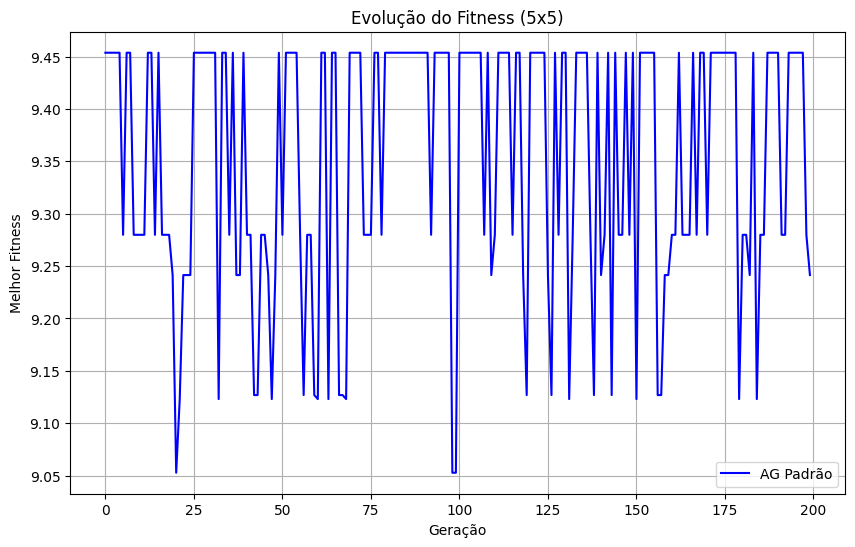

In [17]:
print(history_simple)
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(history_simple)), 
    history_simple, 
    'b-', 
    label='AG Padrão'
)
plt.title('Evolução do Fitness (5x5)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.savefig('evolucao_fitness.png', dpi=300)
plt.show()

0  -  [2.1226543885852167, 2.1378971867755445, 2.1125519918773885, 2.1168791464284356, 2.1378971867755445, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.195292789586617, 2.1378971867755445, 2.2125067804609877, 2.1378971867755445, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.195292789586617, 2.195292789586617, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.195292789586617, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.195292789586617, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877, 2.2125067804609877

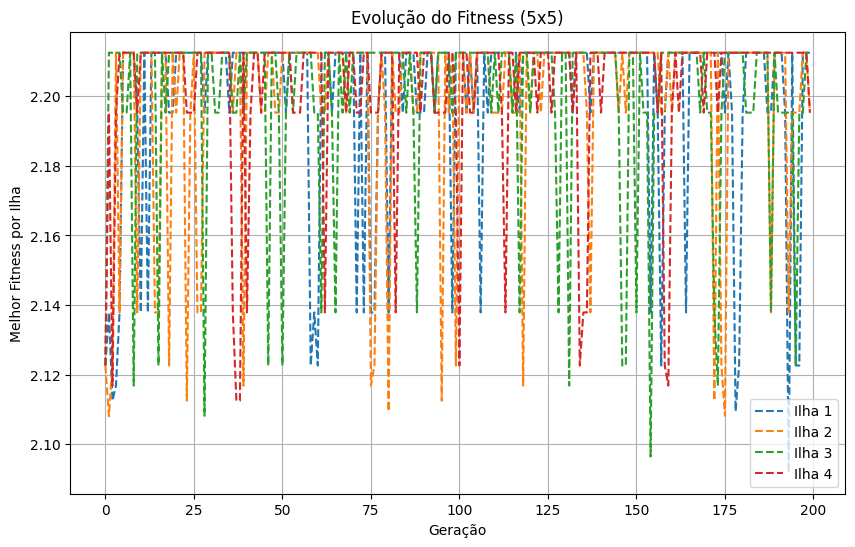

In [18]:
plt.figure(figsize=(10, 6))
for idx, history in enumerate(history_island):
    print(idx , " - " , history)
    plt.plot(
        range(len(history)),
        history,
        linestyle='--',
        label=f'Ilha {idx + 1}'
    )
plt.title('Evolução do Fitness (5x5)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness por Ilha')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.savefig('evolucao_fitness.png', dpi=300)
plt.show()

In [20]:
for size in [50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500]:
    POP_SIZE = size
    best, _ = best_realocate(initial_positions, min_matrix, max_matrix, b)
    print(f"POP_SIZE={size} | Fitness={best.fitness(tester)}")

POP_SIZE=50 | Fitness=2.6641363593105023
POP_SIZE=100 | Fitness=6.893174007719585
POP_SIZE=200 | Fitness=2.3581931585913183
POP_SIZE=500 | Fitness=4.931643860011846
POP_SIZE=1000 | Fitness=3.54272114876585
POP_SIZE=1500 | Fitness=2.6479998294434273
POP_SIZE=2000 | Fitness=1.3935430191922078
POP_SIZE=2500 | Fitness=2.6641363593105023
POP_SIZE=3000 | Fitness=7.526696260124305
POP_SIZE=3500 | Fitness=2.399440346623993


In [84]:
# Testando taxas de mutação
POP_SIZE = 1000
for rate in [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4]:
    MU_TAX = rate
    best, _ = best_realocate(initial_positions, min_matrix, max_matrix, b)
    print(f"Taxa {rate}: Fitness={best.fitness(tester)}")

Taxa 0.01: Fitness=4.282377700254678
Taxa 0.05: Fitness=3.514814465692237
Taxa 0.1: Fitness=1.3111747677901346
Taxa 0.2: Fitness=0.260828502900834
Taxa 0.25: Fitness=3.4081130635928023
Taxa 0.3: Fitness=4.460477061540471
Taxa 0.35: Fitness=3.514814465692237
Taxa 0.4: Fitness=0.24529882331949868


In [85]:
# Migração com diferentes intervalos
POP_SIZE = 1000
MU_TAX = 0.05
for interval in [1, 5, 10, 15, 20, 25, 30]:
    best, _ = best_realocate_island(
        initial_positions,
        min_matrix,
        max_matrix,
        b,
        NUM_ISLAND,
        interval,
        MIGRATION_SIZE,
    )
    print(f"Intervalo {interval}: Fitness={best.fitness(tester)}")

Intervalo 1: Fitness=3.557826395173019
Intervalo 5: Fitness=4.368391826478493
Intervalo 10: Fitness=0.2441248903976241
Intervalo 15: Fitness=4.28877058962181
Intervalo 20: Fitness=3.616216912648469
Intervalo 25: Fitness=3.226904454479826
Intervalo 30: Fitness=3.514814465692237


In [86]:
# Testando diferentes------------------------------------- tamanhos de migração
POP_SIZE = 1000
MU_TAX = 0.05
MIGRATION_INT = 30
for size in [1, 2, 5, 10]:
    best, _ = best_realocate_island(
        initial_positions,
        min_matrix,
        max_matrix,
        b,
        NUM_ISLAND,
        MIGRATION_INT,
        size,
    )
    print(f"Tamanho {size}: Fitness={best.fitness(tester)}")

Tamanho 1: Fitness=3.40346745375153
Tamanho 2: Fitness=0.7488480655790639
Tamanho 5: Fitness=3.3147784583655078
Tamanho 10: Fitness=3.616216912648469
